In [446]:
import torch
import numpy as np
import pandas as pd
from scipy.sparse import dok_matrix
import string
from collections import defaultdict
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score
import seaborn as sns

## Term Document Matrix Generation

In [447]:
def tokenize(document):
    return document.split()

def better_tokenize(document):
    document = (
        document.lower().translate(str.maketrans('','', string.punctuation))
        .replace("\r", " ")
        .replace("\n", " ")
        .replace("\"", "")
        .replace("\'", "")
        )
    return tokenize(document)

def create_word_counts_dict(lines, filter=0, tokenizer=None):
    word_counts = defaultdict(lambda: 0)

    for line in lines:
        if not tokenizer:
            tokens = better_tokenize(line)
        else:
            tokens = tokenizer(line)
        for token in tokens:
            word_counts[token] += 1
    return {k: v for k, v in word_counts.items() if v >= filter}

def to_sparse_tensor(X):
    coo = X.tocoo()
    values = coo.data
    indices = np.vstack((coo.row, coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = coo.shape

    return torch.sparse.FloatTensor(i, v, torch.Size(shape))

def create_term_document_matrix(file_name, include_intercept=False, tokenizer=None):
    lines = pd.read_csv(file_name)
    word_counts = create_word_counts_dict(lines["text"], filter=2, tokenizer=tokenizer)
    word_idx = {k: i for i, k in enumerate(word_counts)}
    V = len(word_counts)
    if include_intercept:
        V += 1
    D = lines.shape[0]
    X = dok_matrix((D, V), dtype=np.int64)
    for i in range(D):
        word_counts_doc = create_word_counts_dict(pd.Series(lines.iloc[i]["text"]))
        if include_intercept:
            X[i,0] = 1
        for word in word_counts_doc:
            if word in word_idx:
                j = word_idx[word]
                X[i,j] = word_counts_doc[word]
    return to_sparse_tensor(X), torch.Tensor(lines["sarcastic"]), word_idx

## PyTorch NN Model Class

In [448]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, 
                 input_dim, 
                 output_dim,
                 epochs=10,
                 learning_rate=1e-2,
                 criterion=None,
                 optimizer=None,
                 max_steps=100000000,
                 step_interval=50
                ):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
        self.epochs = epochs
        self.learning_rate=learning_rate
        if not criterion:
            self.criterion = torch.nn.BCELoss()
        if not optimizer:
            self.optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate)
        self.losses = []
        self.f1_scores = []
        self.max_steps = max_steps
        self.step_interval = step_interval

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

    def evaluate(self, X, y):
        self._evaluate = True
        self.test_X = X
        self.test_y = y

    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

    def train_weights(self, X, y):
        epochs = 0
        steps = 0
        while (epochs < self.epochs) and (steps < self.max_steps):
            epochs += 1
            order = np.arange(X.shape[0])
            np.random.shuffle(order)
            self.train()
            for idx in tqdm(order):
                steps += 1
                if steps == self.max_steps:
                    break
                self.optimizer.zero_grad()
                xi, yi = X[idx], y[idx]
                outputs = self(xi)
                loss = self.criterion(outputs.squeeze(), yi)
                loss.backward()
                self.optimizer.step()
                if self._evaluate and (steps % self.step_interval == 0):
                    self.eval()
                    with torch.no_grad():
                        y_hats = self(self.test_X)
                        self.losses.append(self.criterion(y_hats.squeeze(), self.test_y).item())
                        self.f1_scores.append(
                            f1_score(y_hats.round().squeeze().tolist(), self.test_y.squeeze().tolist())
                        )

## Set up data

In [449]:
X, y, word_idx = create_term_document_matrix("si630w23-hw1.train.csv", include_intercept=False)

In [450]:
test = pd.read_csv("si630w23-hw1.dev.csv")
D = test.shape[0]
X_dev = dok_matrix((D, len(word_idx)), dtype=np.int64)
for idx, sentence in enumerate(test["text"]):
    tokens = better_tokenize(sentence)
    xi = np.zeros(X.shape[1])
    for token in tokens:
        if token in word_idx:
            X_dev[idx, word_idx[token]] += 1
X_dev

<280x4088 sparse matrix of type '<class 'numpy.int64'>'
	with 3437 stored elements in Dictionary Of Keys format>

## Experiments

In [451]:
input_dim = len(word_idx)
output_dim = 1

In [452]:
len(model1.losses)

19

Text(0.5, 1.0, '1000 steps with loss evaluated every 50 steps')

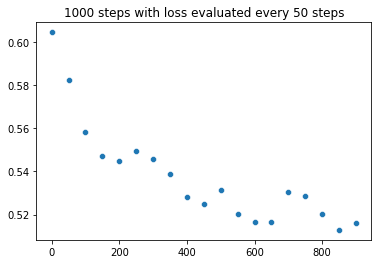

In [453]:
sns.scatterplot(y=model1.losses, x=[i*50 for i in range(len(model1.losses))]).set_title("1000 steps with loss evaluated every 50 steps")

In [454]:
model2 = LogisticRegression(
    input_dim, 
    output_dim,
    epochs=30,
    step_interval=1000
)
model2.evaluate(to_sparse_tensor(X_dev), torch.Tensor(test["sarcastic"]))
model2.train_weights(X, y)

100%|██████████| 3467/3467 [00:01<00:00, 2729.84it/s]


In [455]:
model2.losses[-5:]

[0.47234711050987244,
 0.479209303855896,
 0.4817945659160614,
 0.4717567563056946,
 0.46459028124809265]

In [456]:
model2.f1_scores[-5:]

[0.2727272727272727,
 0.26865671641791045,
 0.2903225806451613,
 0.2622950819672131,
 0.26666666666666666]

In [457]:
model3 = LogisticRegression(
    input_dim, 
    output_dim,
    epochs=10,
    step_interval=50,
)
model3.set_optimizer(torch.optim.SGD(model3.parameters(), lr=1e-2, weight_decay=0))
model3.evaluate(to_sparse_tensor(X_dev), torch.Tensor(test["sarcastic"]))
model3.train_weights(X, y)

100%|██████████| 3467/3467 [00:01<00:00, 2617.31it/s]


In [458]:
model4 = LogisticRegression(
    input_dim, 
    output_dim,
    epochs=10,
    step_interval=50,
)
model4.set_optimizer(torch.optim.SGD(model4.parameters(), lr=1e-2, weight_decay=0.001))
model4.evaluate(to_sparse_tensor(X_dev), torch.Tensor(test["sarcastic"]))
model4.train_weights(X, y)

100%|██████████| 3467/3467 [00:01<00:00, 2596.38it/s]


In [459]:
model5 = LogisticRegression(
    input_dim, 
    output_dim,
    epochs=10,
    step_interval=50,
)
model5.set_optimizer(torch.optim.SGD(model5.parameters(), lr=1e-2, weight_decay=0.1))
model5.evaluate(to_sparse_tensor(X_dev), torch.Tensor(test["sarcastic"]))
model5.train_weights(X, y)

100%|██████████| 3467/3467 [00:01<00:00, 2517.32it/s]


In [460]:
df1 = pd.DataFrame({"loss": model3.losses, "f1": model3.f1_scores, "L2": ["0"] * len(model3.losses)}).reset_index()
df2 = pd.DataFrame({"loss": model4.losses, "f1": model4.f1_scores, "L2": ["0.001"] * len(model4.losses)}).reset_index()
df3 = pd.DataFrame({"loss": model5.losses, "f1": model5.f1_scores, "L2": ["0.1"] * len(model5.losses)}).reset_index()

In [461]:
df = pd.concat([df1, df2, df3])
df

,index,loss,f1,L2
0,0,0.612702,0.0,0
1,1,0.574399,0.0,0
2,2,0.576588,0.0,0
3,3,0.573430,0.0,0
4,4,0.552063,0.0,0
...,...,...,...,...
688,688,0.516286,0.0,0.1
689,689,0.514468,0.0,0.1
690,690,0.513647,0.0,0.1
691,691,0.518241,0.0,0.1


Text(0.5, 1.0, 'Effect of L2 Regularization on Loss')

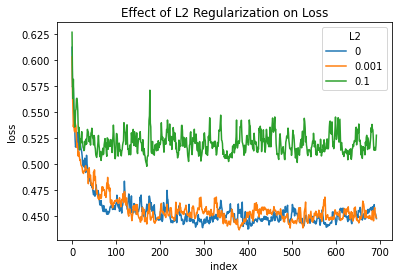

In [462]:
sns.lineplot(data=df, x="index", y="loss", hue="L2").set_title("Effect of L2 Regularization on Loss")

Text(0.5, 1.0, 'Effect of L2 Regularization on F1 Score')

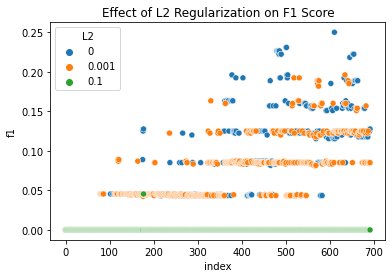

In [463]:
sns.scatterplot(data=df, x="index", y="f1", hue="L2").set_title("Effect of L2 Regularization on F1 Score")

In [464]:
model6 = LogisticRegression(
    input_dim, 
    output_dim,
    epochs=20,
    step_interval=100,
)
model6.set_optimizer(torch.optim.AdamW(model6.parameters(), lr=1e-2))
model6.evaluate(to_sparse_tensor(X_dev), torch.Tensor(test["sarcastic"]))
model6.train_weights(X, y)

100%|██████████| 3467/3467 [00:02<00:00, 1474.08it/s]


In [465]:
model7 = LogisticRegression(
    input_dim, 
    output_dim,
    epochs=20,
    step_interval=100,
)
model7.set_optimizer(torch.optim.RMSprop(model7.parameters(), lr=1e-2))
model7.evaluate(to_sparse_tensor(X_dev), torch.Tensor(test["sarcastic"]))
model7.train_weights(X, y)

100%|██████████| 3467/3467 [00:01<00:00, 2391.38it/s]


In [466]:
df1 = pd.DataFrame({"loss": model6.losses, "f1": model6.f1_scores, "Optimizer": ["AdamW"] * len(model6.losses)}).reset_index()
df2 = pd.DataFrame({"loss": model7.losses, "f1": model7.f1_scores, "Optimizer": ["RMSprop"] * len(model7.losses)}).reset_index()

In [467]:
df = pd.concat([df1, df2])

Text(0.5, 1.0, 'Effect of Optimizer on Loss')

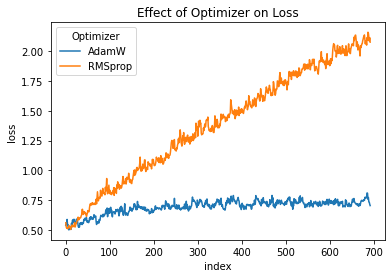

In [468]:
sns.lineplot(data=df, x="index", y="loss", hue="Optimizer").set_title("Effect of Optimizer on Loss")

Text(0.5, 1.0, 'Effect of Optimizer on F1 Score')

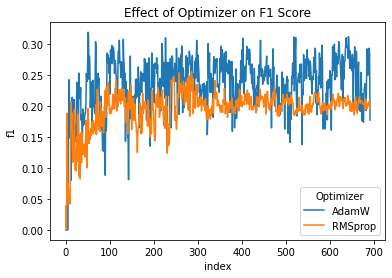

In [469]:
sns.lineplot(data=df, x="index", y="f1", hue="Optimizer").set_title("Effect of Optimizer on F1 Score")

In [470]:
model8 = LogisticRegression(
    input_dim, 
    output_dim,
    epochs=20,
    step_interval=50,
    learning_rate=1e-1
)
model8.evaluate(to_sparse_tensor(X_dev), torch.Tensor(test["sarcastic"]))
model8.train_weights(X, y)

100%|██████████| 3467/3467 [00:01<00:00, 2565.97it/s]


In [471]:
model9 = LogisticRegression(
    input_dim, 
    output_dim,
    epochs=20,
    step_interval=50,
    learning_rate=1e-2
)
model9.evaluate(to_sparse_tensor(X_dev), torch.Tensor(test["sarcastic"]))
model9.train_weights(X, y)

100%|██████████| 3467/3467 [00:01<00:00, 2360.69it/s]


In [472]:
model10 = LogisticRegression(
    input_dim, 
    output_dim,
    epochs=20,
    step_interval=50,
    learning_rate=1e-3
)
model10.evaluate(to_sparse_tensor(X_dev), torch.Tensor(test["sarcastic"]))
model10.train_weights(X, y)

100%|██████████| 3467/3467 [00:01<00:00, 2361.19it/s]


In [473]:
model11 = LogisticRegression(
    input_dim, 
    output_dim,
    epochs=20,
    step_interval=50,
    learning_rate=1e-4
)
model11.evaluate(to_sparse_tensor(X_dev), torch.Tensor(test["sarcastic"]))
model11.train_weights(X, y)

100%|██████████| 3467/3467 [00:01<00:00, 2448.70it/s]


In [474]:
model12 = LogisticRegression(
    input_dim, 
    output_dim,
    epochs=20,
    step_interval=50,
    learning_rate=1e-5
)
model12.evaluate(to_sparse_tensor(X_dev), torch.Tensor(test["sarcastic"]))
model12.train_weights(X, y)

100%|██████████| 3467/3467 [00:01<00:00, 2501.48it/s]


In [475]:
dfs = []
for model in [model8, model9, model10, model11, model12]:
    dfs.append(
        pd.DataFrame({"loss": model.losses, "f1": model.f1_scores, "Learning Rate": [str(model.learning_rate)] * len(model.losses)}).reset_index()
    )
df = pd.concat(dfs)
df

,index,loss,f1,Learning Rate
0,0,0.585987,0.090909,0.1
1,1,0.515681,0.000000,0.1
2,2,0.534339,0.000000,0.1
3,3,0.604685,0.336283,0.1
4,4,0.525268,0.000000,0.1
...,...,...,...,...
1381,1381,0.603414,0.000000,1e-05
1382,1382,0.603396,0.000000,1e-05
1383,1383,0.603390,0.000000,1e-05
1384,1384,0.603360,0.000000,1e-05


Text(0.5, 1.0, 'Effect of Learning Rate on Loss')

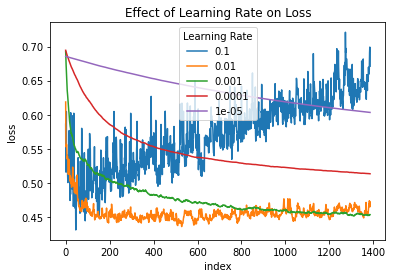

In [476]:
sns.lineplot(data=df, x="index", y="loss", hue="Learning Rate").set_title("Effect of Learning Rate on Loss")

Text(0.5, 1.0, 'Effect of Learning Rate on F1 Score')

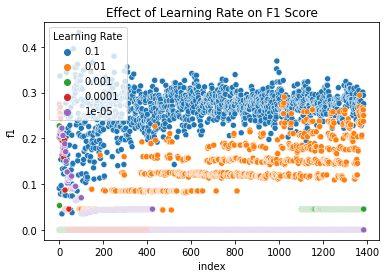

In [477]:
sns.scatterplot(data=df, x="index", y="f1", hue="Learning Rate").set_title("Effect of Learning Rate on F1 Score")

In [478]:
X, y, word_idx = create_term_document_matrix(
    "si630w23-hw1.train.csv", include_intercept=False, tokenizer=tokenize
)

In [479]:
test = pd.read_csv("si630w23-hw1.dev.csv")
D = test.shape[0]
X_dev = dok_matrix((D, len(word_idx)), dtype=np.int64)
for idx, sentence in enumerate(test["text"]):
    tokens = tokenize(sentence)
    xi = np.zeros(X.shape[1])
    for token in tokens:
        if token in word_idx:
            X_dev[idx, word_idx[token]] += 1
X_dev

<280x4407 sparse matrix of type '<class 'numpy.int64'>'
	with 3131 stored elements in Dictionary Of Keys format>

In [480]:
input_dim = len(word_idx)
output_dim = 1

In [481]:
model13 = LogisticRegression(
    input_dim, 
    output_dim,
    epochs=10,
    step_interval=50,
)
model13.evaluate(to_sparse_tensor(X_dev), torch.Tensor(test["sarcastic"]))
model13.train_weights(X, y)

100%|██████████| 3467/3467 [00:01<00:00, 2518.13it/s]


In [482]:
X, y, word_idx = create_term_document_matrix(
    "si630w23-hw1.train.csv", include_intercept=False
)

In [483]:
test = pd.read_csv("si630w23-hw1.dev.csv")
D = test.shape[0]
X_dev = dok_matrix((D, len(word_idx)), dtype=np.int64)
for idx, sentence in enumerate(test["text"]):
    tokens = better_tokenize(sentence)
    xi = np.zeros(X.shape[1])
    for token in tokens:
        if token in word_idx:
            X_dev[idx, word_idx[token]] += 1
X_dev

<280x4088 sparse matrix of type '<class 'numpy.int64'>'
	with 3437 stored elements in Dictionary Of Keys format>

In [484]:
input_dim = len(word_idx)
output_dim = 1

In [485]:
model14 = LogisticRegression(
    input_dim, 
    output_dim,
    epochs=10,
    step_interval=50,
)
model14.evaluate(to_sparse_tensor(X_dev), torch.Tensor(test["sarcastic"]))
model14.train_weights(X, y)

100%|██████████| 3467/3467 [00:01<00:00, 2404.72it/s]


In [486]:
df1 = pd.DataFrame(
    {"loss": model13.losses, "f1": model13.f1_scores, "Tokenizer": ["`tokenize`"] * len(model13.losses)}
).reset_index()
df2 = pd.DataFrame(
    {"loss": model14.losses, "f1": model14.f1_scores, "Tokenizer": ["`better_tokenize`"] * len(model14.losses)}
).reset_index()

In [487]:
df = pd.concat([df1, df2])

Text(0.5, 1.0, 'Effect of Tokenizer on Loss')

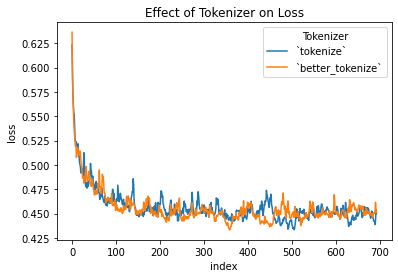

In [488]:
sns.lineplot(data=df, x="index", y="loss", hue="Tokenizer").set_title("Effect of Tokenizer on Loss")

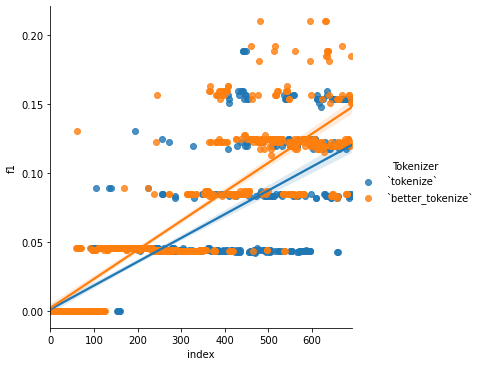

In [489]:
sns.lmplot(data=df, x="index", y="f1", hue="Tokenizer")

## Predict with best model

In [490]:
model8

LogisticRegression(
  (linear): Linear(in_features=4088, out_features=1, bias=True)
  (criterion): BCELoss()
)

In [491]:
test = pd.read_csv("si630w23-hw1.test.csv")
D = test.shape[0]
X_dev = dok_matrix((D, len(word_idx)), dtype=np.int64)
for idx, sentence in enumerate(test["text"]):
    tokens = better_tokenize(sentence)
    xi = np.zeros(X.shape[1])
    for token in tokens:
        if token in word_idx:
            X_dev[idx, word_idx[token]] += 1
X_dev

<1400x4088 sparse matrix of type '<class 'numpy.int64'>'
	with 17595 stored elements in Dictionary Of Keys format>

In [492]:
test.shape

(1400, 2)

In [493]:
y_hats = model8(to_sparse_tensor(X_dev))

In [494]:
pd.Series(y_hats.round().squeeze().tolist(), name="prediction").apply(int).to_csv("nn_submission.csv", index_label="index")

In [495]:
!cat nn_submission.csv

index,prediction
0,0
1,0
2,0
3,0
4,1
5,0
6,0
7,0
8,0
9,0
10,0
11,0
12,0
13,0
14,0
15,1
16,0
17,0
18,0
19,0
20,1
21,0
22,0
23,0
24,0
25,0
26,0
27,0
28,1
29,0
30,0
31,0
32,0
33,0
34,0
35,0
36,0
37,0
38,0
39,0
40,0
41,0
42,0
43,0
44,0
45,0
46,0
47,0
48,0
49,0
50,0
51,0
52,0
53,0
54,0
55,0
56,0
57,0
58,0
59,0
60,0
61,0
62,1
63,0
64,0
65,0
66,1
67,0
68,0
69,0
70,1
71,0
72,0
73,0
74,0
75,0
76,1
77,0
78,0
79,0
80,0
81,0
82,0
83,0
84,1
85,0
86,0
87,1
88,0
89,1
90,0
91,0
92,0
93,0
94,0
95,0
96,0
97,0
98,1
99,1
100,0
101,0
102,0
103,0
104,0
105,0
106,0
107,0
108,0
109,0
110,0
111,0
112,0
113,0
114,0
115,0
116,0
117,1
118,0
119,0
120,0
121,0
122,0
123,0
124,0
125,0
126,0
127,1
128,1
129,0
130,0
131,1
132,0
133,1
134,0
135,0
136,0
137,0
138,0
139,0
140,1
141,0
142,0
143,0
144,0
145,0
146,0
147,0
148,1
149,0
150,1
151,0
152,0
153,1
154,1
155,0
156,1
157,0
158,0
159,0
160,1
161,0
162,0
163,0
164,0
165,0
166,0
167,0
168,0
169,0
170,0
171,0
172,0
173,0
174,0
175,0
176,0
177,0
178,0
179,0
180,0
181,0
1